<h1 style="text-align:center;"> LSTM for Stock Market Prediction</h1>
<h2 style="text-align:center;"> Apple</h2>

<p style="font-size:18px;color:gray;"> <strong>Step 1:</strong> For this Predictive model we will utilize some modules that are necessary to create and visualize this predictive model such as NumPy, Pandas, SciKitlearn, MatPlotLib, and Keras.</p>

In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import datetime as dt
import requests

In [2]:
#Get the Stock quote
url = f"https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?apikey=14f90359650cd4c61f0f33af0a7564d6"
result = requests.get(url).json()


In [3]:
df = pd.DataFrame(result['historical'])
print(result['symbol'])
print(df.shape)
df["date"]=pd.to_datetime(df.date,format="%Y-%m-%d")
df.index = df['date']
df = df[["close"]]

AAPL
(1259, 13)


In [4]:
df = df.iloc[::-1]
df

,close
date,
2016-07-05,23.747499
2016-07-06,23.882500
2016-07-07,23.985001
2016-07-08,24.170000
2016-07-11,24.245001
...,...
2021-06-28,134.780000
2021-06-29,136.330000
2021-06-30,136.960000


Text(0, 0.5, 'Close Price USD')

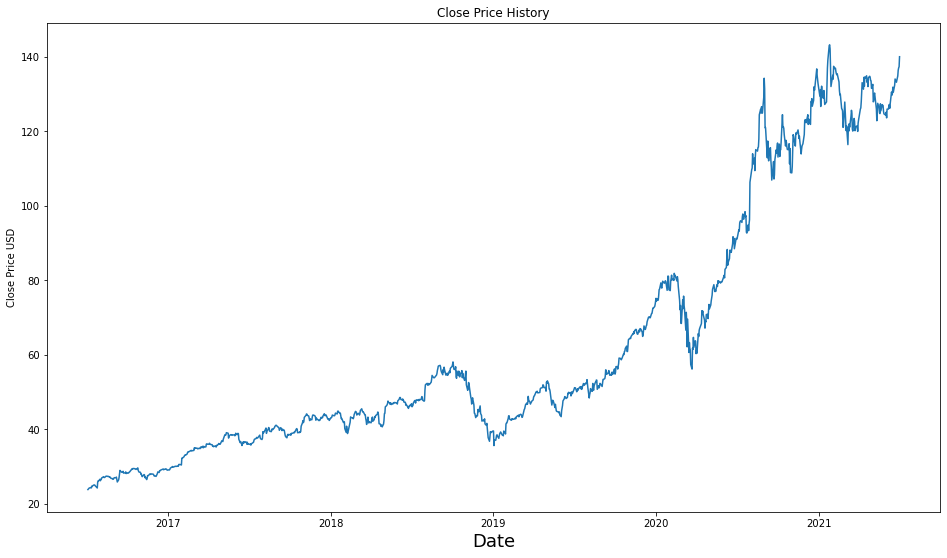

In [5]:
plt.figure(figsize=(16,9))
plt.title("Close Price History")
plt.plot(df['close'])
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD")

In [6]:
# Create New DataFrame with close values
data = df
# Convert Dataframe to Numpy array
dataset = data.values

In [7]:
#Get number of row to train our module
training_data_len = math.ceil(len(dataset) * 0.80)
training_data_len

1008

In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.        ],
       [0.00113054],
       [0.00198892],
       ...,
       [0.94807911],
       [0.95067515],
       [0.9732021 ]])

In [9]:
# Create training Dataset
#create the scaled Training Data Set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)
    print()

[array([0.        , 0.00113054, 0.00198892, 0.00353816, 0.00416625,
       0.00508742, 0.00393595, 0.00795562, 0.00793469, 0.01013295,
       0.0102167 , 0.01040512, 0.00929552, 0.00768347, 0.00491992,
       0.00351723, 0.01666492, 0.019575  , 0.01930284, 0.02315505,
       0.01986812, 0.02261071, 0.0227782 , 0.02614887, 0.02801216,
       0.02893332, 0.02723752, 0.02709097, 0.02761437, 0.03033604,
       0.03012666, 0.0297917 , 0.02949859, 0.0300848 , 0.02830526,
       0.02901707, 0.02730033, 0.02633728, 0.02501833, 0.0247671 ,
       0.02305036, 0.02325972, 0.02457868, 0.02667227, 0.02660944,
       0.02799121, 0.02204543, 0.01704177, 0.02187796, 0.02713284,
       0.03513032, 0.04308595, 0.04172512, 0.03891972, 0.03889878,
       0.03885692, 0.04109705, 0.0370983 , 0.0374542 , 0.03789385])]
[0.03969433519546381]



In [10]:
# convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
samples,time_steps = x_train.shape
print(samples,time_steps)

948 60


In [12]:
# Reshaping the data
x_train = np.reshape((x_train),(samples,time_steps,1))
x_train.shape

(948, 60, 1)

In [13]:
# Building the LSTM Model
model = Sequential()
# Creating Layers
model.add(LSTM(50, return_sequences=True, input_shape=(time_steps,1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compiling the model
# Loss function is used to measure how well the model did on training.
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#training the Model
# Batch size is the total number of training examples present in a single batch
# Epoch is the iterations when an entire dataset is passed forward and backward through a neural network
model.fit(x_train, y_train, batch_size=1, epochs=2,verbose=5)

Epoch 1/2
Epoch 2/2


In [16]:
# creating the Testing dataset 
# Array that contained scaled values test_data = scaled_data[training_data_len - 60:through the end, all columns]

test_data = scaled_data[training_data_len-60: , :]
# Creating testing datasets 
x_test = []
y_test = dataset[training_data_len: , :]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])
  


In [17]:
# Converting data to a numpy Array
x_test = np.array(x_test)


In [18]:
# Reshaping the data, because LST model is expecting a 3 dimensional array
# x_test.shape[0] represents the number of Rows, 
#  x_test.shape[1] represents the number of time steps
# 3rd element in the dimensional array (1) represents the close price
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
# Get the models predicted price values
# This step "unscale" the values

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


Model Evaluation

In [20]:
# Evaluating our model, Getting the root mean error (RMSE), Model accuracy 
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.14334603246194963

Plotting the Data


In [21]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions'] = predictions

C:\Users\admin\anaconda3\envs\PythonAdv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


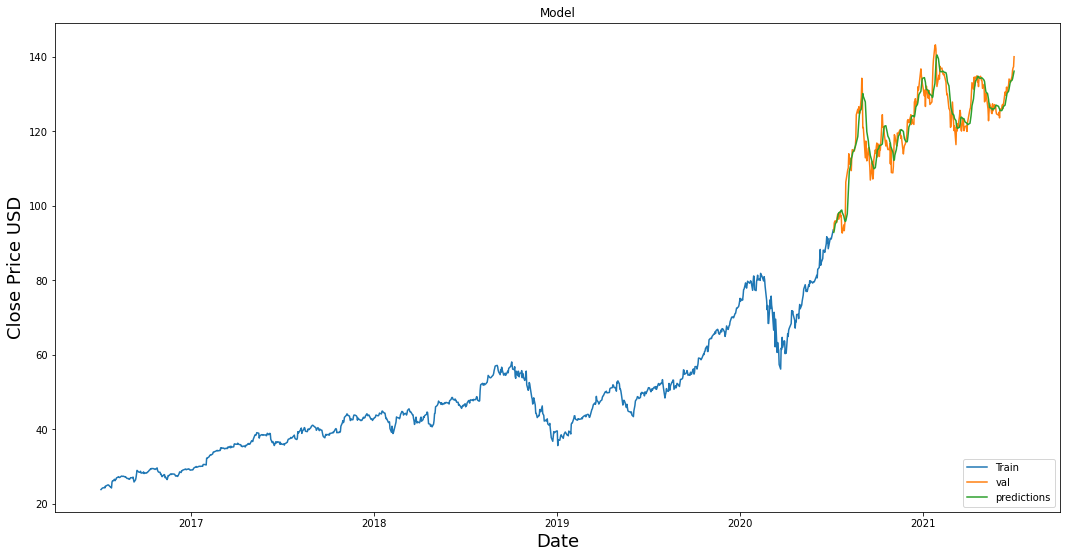

In [22]:
# Visualize the models data
plt.figure(figsize=(18,9))
plt.title('Model')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD", fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close','predictions']])
plt.legend(['Train','val','predictions'], loc='lower right')
plt.show()

In [23]:
# show the Valid(actual prices) and the predicted prices
valid

,close,predictions
date,,
2020-07-07,93.172501,92.812767
2020-07-08,95.342499,93.341072
2020-07-09,95.752502,94.150330
2020-07-10,95.919998,95.025909
2020-07-13,95.477501,95.830910
...,...,...
2021-06-28,134.780000,133.656204
2021-06-29,136.330000,134.059113
2021-06-30,136.960000,134.683716


In [24]:
# Predicting 